In [1]:
# from sympy.assumptions.assume import global_assumptions
# from sympy.assumptions.ask import Q
# global_assumptions.add(Q.real(x))

In [2]:
import numpy as np
from sympy import symbols, cos, sin, Matrix, atan2, acos, sqrt, pi, Array
import sympy
# import mpmath
import matplotlib.pyplot as plt

# Helper functions

In [3]:
def A_dh(theta, d, a, alpha, type, radians = False):
    if not radians and not isinstance(theta, sympy.core.symbol.Symbol):
        theta = theta / 180 * sympy.pi
    if not radians and not isinstance(alpha, sympy.core.symbol.Symbol):
        alpha = alpha / 180 * sympy.pi
    return Matrix([
        [cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
        [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
        [0, sin(alpha), cos(alpha), d],
        [0, 0, 0, 1]
    ])

def A_trans(x, y, z, type):
    return Matrix([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ])
    



# Config
 

In [4]:
theta_1, theta_2, theta_3, theta_4= symbols('theta_1 theta_2 theta_3 theta_4')

In [5]:
dh_conv = {
    1 : {'theta': theta_1, 'd': 50/1000, 'a': 0, 'alpha': 90, 'type': 'revolute'},
    2 : {'theta': theta_2, 'd': 0, 'a': 93/1000, 'alpha': 0, 'type': 'revolute'},
    3 : {'theta': theta_3, 'd': 0, 'a': 93/1000, 'alpha': 0, 'type': 'revolute'},
    4 : {'theta': theta_4, 'd': 0, 'a': 50/1000, 'alpha': 0, 'type': 'revolute'},
    5: {'x' : -15/1000, 'y' : 45/1000, 'z' : 0, 'type': 'transformation'}
}



In [6]:
for i, a in dh_conv.items():
    print(a)

{'theta': theta_1, 'd': 0.05, 'a': 0, 'alpha': 90, 'type': 'revolute'}
{'theta': theta_2, 'd': 0, 'a': 0.093, 'alpha': 0, 'type': 'revolute'}
{'theta': theta_3, 'd': 0, 'a': 0.093, 'alpha': 0, 'type': 'revolute'}
{'theta': theta_4, 'd': 0, 'a': 0.05, 'alpha': 0, 'type': 'revolute'}
{'x': -0.015, 'y': 0.045, 'z': 0, 'type': 'transformation'}


In [7]:
A = {
    '01' : A_dh(**dh_conv[1]),
    '12' : A_dh(**dh_conv[2]),
    '23' : A_dh(**dh_conv[3]),
    '34' : A_dh(**dh_conv[4]),
    '45' : A_trans(**dh_conv[5])
}

In [8]:
T = {
    '00' : sympy.eye(4),
    '01' : sympy.simplify(A['01']),
    '02' : sympy.simplify(A['01']*A['12']),
    '03' : sympy.simplify(A['01']*A['12']*A['23']),
    '04' : sympy.simplify(A['01']*A['12']*A['23']*A['34']),
    '05' : sympy.simplify(A['45']*A['01']*A['12']*A['23']*A['34'])
}

In [12]:
def jacobian_inner(t, joint, o_n):
    joint_type = joint['type']
    z = t[:3,2]
    o = t[:3,3]
    
    if joint_type == 'revolute':
        j = z.cross(o_n - o)
        return Matrix.vstack(j, z)
    else: # prismatic
        return Matrix.vstack(z, Matrix.zeros(3,1))
    

def jacobian(T_, joints):
    o_n = T_[-1][:3,3]
    J = Matrix.zeros(6, len(joints))
    for idx, joint in enumerate(joints):
        t = T_[idx]
        j = jacobian_inner(t, joint, o_n)
        
        J[:, idx] = j
        
    return sympy.simplify(J)

# def jacobian_all(T_, dh_conv_):
#     J = {}
#     for idx, joint in enumerate(dh_conv_):
#         t = list(T_.values())[:idx+1]
#         joints = list(dh_conv_.values())[:idx+1]
#         J[idx] = jacobian(t, joints)
#     return J

In [13]:
J_end = jacobian(list(T.values())[:5], list(dh_conv.values())[:4])
J_end


Matrix([
[-(0.093*cos(theta_2) + 0.093*cos(theta_2 + theta_3) + 0.05*cos(theta_2 + theta_3 + theta_4))*sin(theta_1), (-0.093*sin(theta_2) - 0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*cos(theta_1), (-0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*cos(theta_1), -0.05*sin(theta_2 + theta_3 + theta_4)*cos(theta_1)],
[ (0.093*cos(theta_2) + 0.093*cos(theta_2 + theta_3) + 0.05*cos(theta_2 + theta_3 + theta_4))*cos(theta_1), (-0.093*sin(theta_2) - 0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*sin(theta_1), (-0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*sin(theta_1), -0.05*sin(theta_1)*sin(theta_2 + theta_3 + theta_4)],
[                                                                                                        0,                                        0.093*cos(theta_2) + 0.093*cos(theta_2 + t

In [14]:
def point_on_circle(phi: float, radius: float = 32/1000):
    centre = Array([150/1000, 0, 120/1000])
    return centre + radius * Array([0, cos(phi), sin(phi)])

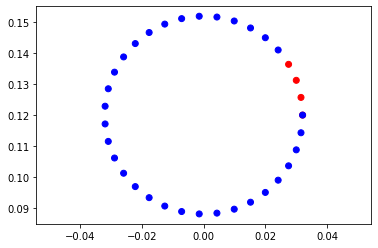

In [15]:
points = [point_on_circle(phi) for phi in np.linspace(0, 2*np.pi, 36)]
cols = ['red'] * 4 + ['blue'] * 32
plt.scatter([p[1] for p in points], [p[2] for p in points], c=cols)
plt.axis('equal')
plt.show()

In [16]:
def inv_kinematics(x,y,z,phi, dh_conv):
    """
    Hardcoded inverse kinematics for the robot arm
    """
    
    theta1 = atan2(y, x)
    
    a2 = dh_conv[2]['a']
    a3 = dh_conv[3]['a']
    a4 = dh_conv[4]['a']
    
    d1 = dh_conv[1]['d']
    
    r = sqrt(x**2 + y**2)
    r2 = cos(phi)*a4
    
    #Given r = r1 + r2
    r1 = r - r2
    
    z1 = d1
    z3 = sin(phi)*a4
    
    #Given z = z1 + z2 + z3
    z2 = z - z1 - z3
    
    c23 = sqrt(z2**2 + r1**2)
    
    c3 = ((c23**2) - (a2**2) - (a3**2)) / (2*a2*a3)
    
    
    D = (c23**2 - a2**2 - a3**2)/(-2*a2*a3)
    theta3 = -(atan2(sqrt(1-D**2), D) - pi)

    
    theta2 = atan2(z2, r1) - atan2(a3*sin(theta3), a2 + a3*cos(theta3))
    
    theta4 = phi - theta2 - theta3
    
    
    return theta1, theta2, theta3, theta4

inv_kinematics(-0.032,0.15, 0.12, 0, dh_conv)


(-1.36061374013273 + pi,
 -0.239730216951784,
 -1.47169003299079 + pi,
 1.71142024994257 - pi)

In [17]:
def jacobian_point(J, _theta_1, _theta_2, _theta_3, _theta_4):
    """Computes jacobian given joint angles"""
    res = sympy.lambdify((theta_1, theta_2, theta_3, theta_4), J, 'sympy')
    return res(_theta_1, _theta_2, _theta_3, _theta_4)

def jacobian_circle_angle(J, phi, end_angle, dh_conv):
    """Computes jacobian given an angle of a circle"""
    
    point_on_circle(phi) #Compute coordinates of point on circle
    
    #Compute angles of joints
    _theta_1, _theta_2, _theta_3, _theta_4 = inv_kinematics(*point_on_circle(phi), end_angle, dh_conv)
    

    #Compute jacobian
    return jacobian_point(J, _theta_1, _theta_2, _theta_3, _theta_4)


In [ ]:
J_end = jacobian(list(T.values())[:5], list(dh_conv.values())[:4])

# r1 = jacobian_circle_angle(J_end,        0, 0, dh_conv)
# r2 = jacobian_circle_angle(J_end,     pi/2, 0, dh_conv)
r3 = jacobian_circle_angle(J_end,       pi, 0, dh_conv)
# r4 = jacobian_circle_angle(J_end, 3*pi / 2, 0, dh_conv)

# print(np.array(r1))
# print(np.array(r2))
# print((r3))
# print(np.array(r4))

[[  32.   -68.5  -90.1    0. ]
 [ 150.    14.6   19.2    0. ]
 [   0.   153.4   63.    50. ]
 [   0.  -208.6 -208.6 -208.6]
 [   0.  -978.  -978.  -978. ]
 [1000.     0.     0.     0. ]]


In [ ]:
J_cam = jacobian(list(T.values())[:6], list(dh_conv.values())[:5])
J_cam

ROUNDING_FACTOR = 1

r1 = jacobian_circle_angle(J_cam,        0, 0, dh_conv)
r2 = jacobian_circle_angle(J_cam,     pi/2, 0, dh_conv)
r3 = jacobian_circle_angle(J_cam,       pi, 0, dh_conv)
r4 = jacobian_circle_angle(J_cam, 3*pi / 2, 0, dh_conv)

print(np.round(np.array(r1).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r2).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r3).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r4).astype(np.float64), ROUNDING_FACTOR))

[[ -77.   -68.5  -90.1    0.   208.6]
 [ 135.   -14.6  -19.2    0.  -978. ]
 [   0.   148.1   57.8   44.7    0. ]
 [   0.   208.6  208.6  208.6    0. ]
 [   0.  -978.  -978.  -978.     0. ]
 [1000.     0.     0.     0.     0. ]]
[[  -45.   -102.    -92.7     0.      0. ]
 [  135.      0.      0.      0.  -1000. ]
 [    0.    135.     42.5    35.      0. ]
 [    0.      0.      0.      0.      0. ]
 [    0.  -1000.  -1000.  -1000.      0. ]
 [ 1000.      0.      0.      0.      0. ]]
[[ -13.   -68.5  -90.1    0.  -208.6]
 [ 135.    14.6   19.2    0.  -978. ]
 [   0.   129.3   39.    25.9    0. ]
 [   0.  -208.6 -208.6 -208.6    0. ]
 [   0.  -978.  -978.  -978.     0. ]
 [1000.     0.     0.     0.     0. ]]
[[  -45.    -38.    -90.1     0.      0. ]
 [  135.      0.      0.      0.  -1000. ]
 [    0.    135.     58.     35.      0. ]
 [    0.      0.      0.      0.      0. ]
 [    0.  -1000.  -1000.  -1000.      0. ]
 [ 1000.      0.      0.      0.      0. ]]


## Problem 5

In [20]:
def temporal_rate(R, w) -> np.ndarray:
    x_dot = np.array([
        [R[2,0] * w[1] - R[1,0] * w[2], R[2,1] * w[1] - R[1,1] * w[2], R[2,2] * w[1] - R[1,2] * w[2]],
        [R[0,0] * w[2] - R[2,0] * w[0], R[0,1] * w[2] - R[2,1] * w[0], R[0,2] * w[2] - R[2,2] * w[0]],
        [R[1,0] * w[0] - R[0,0] * w[1], R[1,1] * w[0] - R[0,1] * w[1], R[1,2] * w[0] - R[0,2] * w[1]],
    ])
    return x_dot

def joint_velocity(J_end, phi, velocity, end_angle, dh_conv):
    M = jacobian_circle_angle(J_end, phi, end_angle, dh_conv)[0:3, :] 

    N = (M.H * M) ** -1 * M.H
    
    q = N * velocity
    
    return q
    

In [21]:
joint_velocity(J_end, 0, vel, 0, dh_conv)

NameError: name 'vel' is not defined

## Problem 6

In [ ]:
def interpolation_polynomial(dh_conv, start_angle, end_angle, t_in, t_end, start_vel, end_vel):
    """Computes polynomial interpolation"""
    point_start = point_on_circle(start_angle)
    point_end   = point_on_circle(  end_angle)
    q_in        = inv_kinematics(*point_start, 0, dh_conv)
    q_end       = inv_kinematics(*point_end,   0, dh_conv)
    
    A_list = []
    points = []
    # print(t_in, t_end)
    for i in range(4):
        b = Matrix([q_in[i], start_vel[i], 0, q_end[i], end_vel[i], 0])
        
        M = Matrix([
            [1,  t_in,   t_in**2,     t_in**3,      t_in**4,      t_in**5],
            [0,     1,    2*t_in,   3*t_in**2,    4*t_in**3,    5*t_in**4],
            [0,     0,         2,      6*t_in,   12*t_in**2,   20*t_in**3],
            [1, t_end,  t_end**2,    t_end**3,     t_end**4,     t_end**5],
            [0,     1,   2*t_end,  3*t_end**2,   4*t_end**3,   5*t_end**4],
            [0,     0,         2,     6*t_end,  12*t_end**2,  20*t_end**3]
        ])

        M_inv = M.inv()

        A = M_inv * b
        
        A_list.append(A)
        points.append(point_start)
        
        
    return A_list, points

In [ ]:
def calc_segments(dh_conv, J_end, n_points, velocities, total_time = 8):
    """Computes the joint angles for a given number of points"""
    
    segments = []
    times    = []
    points   = []
    angles   = np.linspace(0, 2*np.pi, n_points)

    t_start = 0
    t_end = total_time / n_points
    
    _joint_velocity = []
    for phi, vel in zip(angles, velocities):
        _joint_velocity.append(joint_velocity(J_end, phi, vel, 0, dh_conv))
    
    for i in range(len(angles) - 1):
        start_angle = angles[i]
        _start_vel  = _joint_velocity[i]
        
        end_angle   = angles[i + 1]
        _end_vel    = _joint_velocity[i + 1]
                
        seq, seq_points = interpolation_polynomial(dh_conv, start_angle, end_angle, t_start, t_end, _start_vel, _end_vel)
        segments.append(seq)
        
        points.extend(seq_points)
        times.append(t_end)    
        
    return segments, np.array(points), times

In [ ]:
def angular_velocity(phi, velocity):
    ang_vel = Matrix([0, cos(phi+pi/2) * velocity, sin(phi+pi/2) * velocity])
    ang_vel_size = ang_vel[0]**2 + ang_vel[1]**2 + ang_vel[2]**2
    
    assert round(float(ang_vel_size),8) == round(float(velocity**2),8)
    return ang_vel

In [ ]:
N_POINTS = 5

velocities = [Matrix([0,0,0])] + [angular_velocity(phi, 27/1000) for phi in np.linspace(0, float(2*pi), N_POINTS)[1:-1]] + [Matrix([0,0,0])]
_segments, _points, times = calc_segments(dh_conv, J_end, N_POINTS, velocities)


In [ ]:
for v in velocities:
    print(v)

In [ ]:
points = []
transform_matrix = sympy.lambdify((theta_1, theta_2, theta_3, theta_4), T['04'], 'sympy')
for index, segment_i in enumerate(_segments):
    times_i = np.linspace(0, times[index], 10)
    for t_i in times_i:
        T_i = Matrix([1, t_i, t_i**2, t_i**3, t_i**4, t_i**5]).T

        Q_a = Matrix([ T_i @ seq_i for seq_i in segment_i])

        _theta_1, _theta_2, _theta_3, _theta_4 = Q_a
        
        transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4)

        origin = np.array([0, 0, 0, 1])

        joint_position = transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4) @ origin

        points.append(joint_position[:3])
        # print(_theta_1, _theta_2, _theta_3, _theta_4)
    
points = np.array(points).astype(np.float64)

x,  y,  z  =  points[:,0],  points[:,1],  points[:,2]
xp, yp, zp = _points[:,0], _points[:,1], _points[:,2]

In [ ]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(20,5))
axs[0].remove()
axs[0] = fig.add_subplot(1,3,1)

axs[0].scatter(yp,zp)
axs[0].plot(y,z)
axs[0].set_xlabel('Y')
axs[0].set_ylabel('Z')
axs[0].axis('equal')

# cols = ['red'] + ['green'] * (len(points)-2) + ['blue']
axs[1].scatter(xp, yp, zp)
# axs[1].scatter(y, z, c = cols)
axs[1].plot(x, y, z)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
axs[1].axis('equal')
axs[1].view_init(elev=15, azim=90, roll=0)

axs[2].scatter(xp, yp, zp)
# axs[2].scatter(y, z, c = cols)
axs[2].plot(x, y, z)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_zlabel('Z')
axs[2].axis('equal')
axs[2].view_init(elev=15, azim=-30, roll=0)
plt.tight_layout()
plt.show()

In [ ]:
# blocker
raise Exception

In [ ]:
points = []

transform_matrix = sympy.lambdify((theta_1, theta_2, theta_3, theta_4), T['04'], 'sympy')
for phi in np.linspace(0, 2*np.pi, 36):
    _theta_1, _theta_2, _theta_3, _theta_4 = inv_kinematics(*point_on_circle(phi), 0, dh_conv)

    transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4)

    origin = np.array([0, 0, 0, 1])

    joint_position = transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4) @ origin

    points.append(joint_position[:3])
    
points = np.array(points).astype(np.float64)

In [ ]:
x, y, z = points[:, 0], points[:, 1], points[:, 2]

In [ ]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
# cols = ['red'] + ['green'] * (len(points)-2) + ['blue']
axs[0].scatter(xp, yp, zp)
# axs[0].scatter(y, z, c = cols)
axs[0].plot(x, y, z)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
axs[0].axis('equal')
axs[0].view_init(elev=15, azim=20, roll=0)
axs[1].scatter(xp, yp, zp)
# axs[0].scatter(y, z, c = cols)
axs[1].plot(x, y, z)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
axs[1].axis('equal')
axs[1].view_init(elev=15, azim=90, roll=0)
plt.show()

## Problem 8

In [ ]:
angles = np.linspace(0, 2*np.pi, 36)
conditions = [np.linalg.cond(np.array(jacobian_circle_angle(J_cam, phi, 0, dh_conv)).astype(np.float64)) for phi in angles]

In [ ]:
max(conditions)